# Thiết lập môi trường tổng

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.pardir))

# Thêm đường dẫn gốc vào sys.path nếu chưa có
if project_root not in sys.path:
    sys.path.append(project_root)

# Kiểm tra xem đã nhận chưa
print(f"Project Root: {project_root}")

Project Root: d:\University\HK7\IT_Project\Project\Source


# Khai báo thư viện / modules cần thiết

In [2]:
from utils.config import PathConfig
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
from collections import Counter
from pathlib import Path

In [3]:
TARGET_SIZE = 256
INTERPOLATION = Image.BICUBIC
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

# Phân tích tập dữ liệu

In [5]:
def is_image_file(filename):
    return filename.lower().endswith(VALID_EXTENSIONS)

def analyze_image_sizes(src_dir, max_print=10):
    """
    Thống kê kích thước ảnh trong thư mục
    """
    size_counter = Counter()
    total = 0
    failed = 0

    src_dir = Path(src_dir)
    images = [p for p in src_dir.rglob("*") if is_image_file(p.name)]

    print(f"\nAnalyzing image sizes in: {src_dir}")
    print(f"Total images found: {len(images)}")

    for img_path in tqdm(images):
        try:
            with Image.open(img_path) as img:
                size = img.size  # (W, H)
                size_counter[size] += 1
                total += 1
        except Exception as e:
            print(f"[ERROR] {img_path}: {e}")
            failed += 1

    print(f"\nValid images: {total} | Failed: {failed}")

    print("\nMost common image sizes:")
    for size, count in size_counter.most_common(max_print):
        ratio = count / total * 100
        print(f"  {size} : {count} images ({ratio:.2f}%)")

    print("\nSummary:")
    widths = [w for (w, h), c in size_counter.items() for _ in range(c)]
    heights = [h for (w, h), c in size_counter.items() for _ in range(c)]

    print(f"  Unique sizes: {len(size_counter)}")
    print(f"  Min size: {min(widths)} x {min(heights)}")
    print(f"  Max size: {max(widths)} x {max(heights)}")

    return size_counter

In [6]:
real_sizes = analyze_image_sizes(PathConfig.RAW_REAL_IMGS)
fake_sizes = analyze_image_sizes(PathConfig.RAW_AI_GEN_IMGS)


Analyzing image sizes in: ..\..\Datasets\Real
Total images found: 10000


100%|██████████| 10000/10000 [01:40<00:00, 99.56it/s]



Valid images: 10000 | Failed: 0

Most common image sizes:
  (1024, 1024) : 10000 images (100.00%)

Summary:
  Unique sizes: 1
  Min size: 1024 x 1024
  Max size: 1024 x 1024

Analyzing image sizes in: ..\..\Datasets\AI_Generated
Total images found: 9809


100%|██████████| 9809/9809 [00:40<00:00, 244.94it/s]


Valid images: 9809 | Failed: 0

Most common image sizes:
  (200, 200) : 4000 images (40.78%)
  (160, 160) : 3000 images (30.58%)
  (256, 256) : 2000 images (20.39%)
  (244, 244) : 809 images (8.25%)

Summary:
  Unique sizes: 4
  Min size: 160 x 160
  Max size: 256 x 256


# Downsample - resize về cùng kích thước

In [7]:
def resize_and_center_crop(img: Image.Image, size: int) -> Image.Image:
    """
    Resize giữ aspect ratio + center crop về (size, size)
    """
    w, h = img.size

    # Scale sao cho cạnh nhỏ >= size
    scale = size / min(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    img = img.resize((new_w, new_h), INTERPOLATION)

    # Center crop
    left = (new_w - size) // 2
    top = (new_h - size) // 2
    right = left + size
    bottom = top + size

    return img.crop((left, top, right, bottom))


def preprocess_folder(input_dir: str, output_dir: str):
    os.makedirs(output_dir, exist_ok=True)

    image_files = [
        f for f in os.listdir(input_dir)
        if f.lower().endswith(VALID_EXTENSIONS)
    ]

    print(f"\nProcessing: {input_dir}")
    print(f"Total images: {len(image_files)}")

    failed = 0

    for fname in tqdm(image_files):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname)

        try:
            img = Image.open(in_path).convert("RGB")
            img = resize_and_center_crop(img, TARGET_SIZE)
            img.save(out_path, quality=95, subsampling=0)

        except Exception as e:
            failed += 1
            print(f"[ERROR] {fname}: {e}")

    print(f"Done. Failed images: {failed}")

In [8]:
preprocess_folder(PathConfig.RAW_REAL_IMGS, PathConfig.REAL_IMGS)


Processing: ..\..\Datasets\Real
Total images: 10000


100%|██████████| 10000/10000 [05:28<00:00, 30.44it/s]

Done. Failed images: 0


In [9]:
preprocess_folder(PathConfig.RAW_AI_GEN_IMGS, PathConfig.AI_GEN_IMGS)


Processing: ..\..\Datasets\AI_Generated
Total images: 9809


100%|██████████| 9809/9809 [02:34<00:00, 63.40it/s]

Done. Failed images: 0


# Xử lý và chia dữ liệu

In [3]:
def load_image_paths(image_dir, label_code: int):
    image_paths = []
    labels = []
    
    # Load image
    with os.scandir(image_dir) as entries:
        valid_entries = [entry for entry in entries if entry.is_file() and entry.name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for entry in tqdm(valid_entries, desc=f"Xử lý {os.path.basename(image_dir)}"):
            try:
                Image.open(entry.path).verify() 
                image_paths.append(entry.path)
                labels.append(label_code)
            except:
                print(f"Ảnh lỗi: {entry.path}, bỏ qua.")
                
    return image_paths, labels


def collect_data_paths(real_dir='data/Real', ai_dir='data/AI_Generated'):
    paths = []
    labels = []  # 0: Real, 1: AI_Generated
    
    # Load Real
    real_paths, real_labels = load_image_paths(real_dir, 0)
    paths.extend(real_paths)
    labels.extend(real_labels)

    # Load AI_Generated
    ai_paths, ai_labels = load_image_paths(ai_dir, 1)
    paths.extend(ai_paths)
    labels.extend(ai_labels)
    
    print(f"Tổng số ảnh hợp lệ: {len(paths)} (Real: {labels.count(0)}, AI: {labels.count(1)})")
    return paths, labels

image_paths, image_labels = collect_data_paths(PathConfig.REAL_IMGS, PathConfig.AI_GEN_IMGS)

Xử lý Fake: 100%|██████████| 4630/4630 [00:44<00:00, 103.72it/s]

Tổng số ảnh hợp lệ: 9410 (Real: 4780, AI: 4630)


In [4]:
def split_and_save_data(paths, labels, output_dir='split_data', test_size=0.2, val_size=0.1, random_state=42):
    # Tạo thư mục output nếu chưa có
    os.makedirs(output_dir, exist_ok=True)
    
    # Chia train/test
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
    
    # Chia val từ train
    val_ratio = val_size / (1 - test_size)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=val_ratio, stratify=train_labels, random_state=random_state
    )
    
    # Lưu vào CSV: Mỗi file có cột 'path' và 'label'
    def save_to_csv(paths_list, labels_list, file_name):
        df = pd.DataFrame({'path': paths_list, 'label': labels_list})
        df.to_csv(os.path.join(output_dir, file_name), index=False)
        print(f"Đã lưu {file_name} với {len(paths_list)} mẫu")
    
    save_to_csv(train_paths, train_labels, 'train.csv')
    save_to_csv(val_paths, val_labels, 'val.csv')
    save_to_csv(test_paths, test_labels, 'test.csv')


# Chia và lưu dữ liệu
split_and_save_data(image_paths, image_labels, output_dir=PathConfig.SPILTTED_DATASETS)

Đã lưu train.csv với 6587 mẫu
Đã lưu val.csv với 941 mẫu
Đã lưu test.csv với 1882 mẫu


# Trực quan phân bố các tập dữ liệu

In [5]:
def load_split_data(output_dir: str):
    train_df = pd.read_csv(os.path.join(output_dir, 'train.csv'))
    val_df = pd.read_csv(os.path.join(output_dir, 'val.csv'))
    test_df = pd.read_csv(os.path.join(output_dir, 'test.csv'))
    return train_df, val_df, test_df


train_data, val_data, test_data = load_split_data(PathConfig.SPILTTED_DATASETS)
print(f"Tập Train: {len(train_data)}, Tập Val: {len(val_data)}, Tập Test: {len(test_data)}")

Tập Train: 6587, Tập Val: 941, Tập Test: 1882


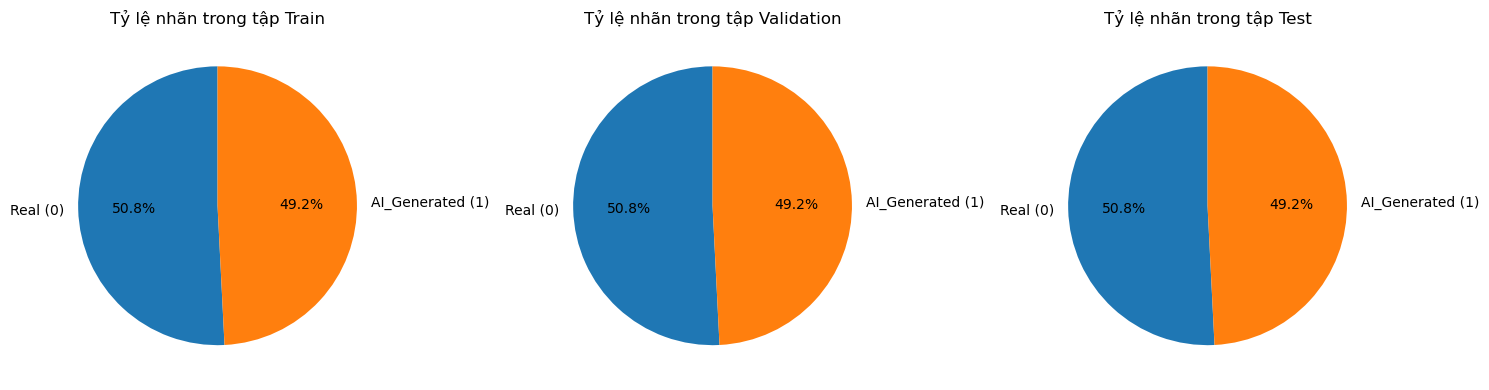

In [6]:
def visualize_label_ratios(df_list: list[pd.DataFrame], titles: list[str]):
    # Tạo figure với 3 subplot
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    for i in range(3):
        # Đếm tỷ lệ nhãn (normalize để lấy phần trăm)
        label_counts = df_list[i]['label'].value_counts(normalize=True) * 100
        
        # Vẽ pie chart
        axs[i].pie(label_counts, labels=['Real (0)', 'AI_Generated (1)'], autopct='%1.1f%%', startangle=90)
        axs[i].set_title(titles[i])

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()


list_of_dfs = [train_data, val_data, test_data]
titles = ['Tỷ lệ nhãn trong tập Train', 'Tỷ lệ nhãn trong tập Validation', 'Tỷ lệ nhãn trong tập Test']
visualize_label_ratios(list_of_dfs, titles)